In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import logging
import galsim
#import random
import cmath as cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import scipy
import scipy.integrate 
#import math

# Parameters to fix

In [2]:
# Parameters
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load the catalog

In [3]:
cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits', dir='/sps/lsst/users/barcelin/COSMOS_25.2_training_sample')

In [4]:
cosmos_cat.nobjects

81499

# Generation function

In [5]:
gal = cosmos_cat.makeGalaxy(np.random.randint(cosmos_cat.nobjects), gal_type='parametric', chromatic=True, noise_pad_size = 0)

gal = gal.rotate(0.5* 360. * galsim.degrees)
redshift = gal.SED.redshift
#shear = gal.getshear()

In [6]:
gal.gsparams

galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)

In [7]:
print(redshift)

1.5351999998092651


In [8]:
print(shear)

NameError: name 'shear' is not defined

In [9]:
# On reprend le générateur précédent, on modifie le tirage sur le redshift pour prendr en compte la distribution
# de galaxies avec le redshift attendue pour LSST (à partir du Science Book LSST)

def Gal_generator_noisy():
    count = 0
    galaxy = np.zeros((10))
    while (galaxy.all() == 0):
        try:
            path, filename = os.path.split('__file__')    
            datapath = galsim.meta_data.share_dir
            datapath2 = os.path.abspath(os.path.join(path,'/sps/lsst/users/barcelin/EUCLID_Filters/'))

            # initialize (pseudo-)random number generator
            random_seed = 1234567
            rng = galsim.BaseDeviate(random_seed+1)

                    # read in the Euclid NIR filters
            filter_names_euclid_nir = 'HJY'
            filter_names_euclid_vis = 'V'

            # read in the LSST filters
            filter_names_lsst = 'ugrizy'
            filters = {}


            for filter_name in filter_names_euclid_nir:
                filter_filename = os.path.join(datapath2, 'Euclid_NISP0.{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_euclid_vis:
                filter_filename = os.path.join(datapath2, 'Euclid_VIS.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            for filter_name in filter_names_lsst:
                filter_filename = os.path.join(datapath, 'bandpasses/LSST_{0}.dat'.format(filter_name))
                filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='nm')
                filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

            pixel_scale_lsst = 0.2 # arcseconds # LSST Science book
            pixel_scale_euclid_nir = 0.3 # arcseconds # Euclid Science book
            pixel_scale_euclid_vis = 0.1 # arcseconds # Euclid Science book


            ############## SHAPE OF THE GALAXY ##################
            ud = galsim.UniformDeviate()
            gal = cosmos_cat.makeGalaxy(np.random.randint(cosmos_cat.nobjects), gal_type='parametric', chromatic=True, noise_pad_size = 0)

            gal = gal.rotate(ud() * 360. * galsim.degrees)
            redshift = gal.SED.redshift
            shear = gal.shear

            #################### NOISE ###################
            # Poissonian noise according to sky_level
            N_exposures = 100
            
            
            sky_level_lsst_u = (2.512 **(26.50-22.95)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_g = (2.512 **(28.30-22.24)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_r = (2.512 **(28.13-21.20)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_i = (2.512 **(27.79-20.47)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_z = (2.512 **(27.40-19.60)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_lsst_y = (2.512 **(26.58-18.63)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_lsst = [int((sky_level_lsst_u * 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_g* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_r* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_i* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_z* 15 * pixel_scale_lsst**2)),
                                   int((sky_level_lsst_y* 15 * pixel_scale_lsst**2))]# in e-/pixel/15s

            # average background level for Euclid observations : 22.35 mAB.arcsec-2 in VIS (Consortium book) ##
            # For NIR bands, a coefficient is applied : it is calculated by comparing magnitudes AB of one point in the
            # sky to the magnitude AB in VIS on this point. The choosen point is (-30;30) in galactic coordinates 
            # (EUCLID and LSST overlap on this point).
            coeff_noise_y = (22.57/21.95)
            coeff_noise_j = (22.53/21.95)
            coeff_noise_h = (21.90/21.95)
            
            sky_level_nir_Y = (2.512 **(24.25-22.35*coeff_noise_y)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_J = (2.512 **(24.29-22.35*coeff_noise_j)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_nir_H = (2.512 **(24.92-22.35*coeff_noise_h)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_vis = (2.512 **(25.58-22.35)) * N_exposures # in e-.s-1.arcsec_2
            sky_level_pixel_nir = [int((sky_level_nir_Y * 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_J* 1800 * pixel_scale_euclid_nir**2)),
                                   int((sky_level_nir_H* 1800 * pixel_scale_euclid_nir**2))]# in e-/pixel/1800s
            sky_level_pixel_vis = int((sky_level_vis * 1800 * pixel_scale_euclid_vis**2))# in e-/pixel/1800s
            
            
            ############ LUMINOSITY ############# 
            # The luminosity is multiplied by the ratio of the noise in the LSST R band and the assumed cosmos noise             
            bdgal_lsst =  (15. * (6.68**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_nir =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures
            bdgal_euclid_vis =  (1800. * ((1.25)**2 - (0.37)**2)/((2.4**2)*(1.-0.33**2))) * gal * N_exposures         
            
            
            
            ########### PSF #####################
            # convolve with PSF to make final profil : profil from LSST science book and (https://arxiv.org/pdf/0805.2366.pdf)
            mu = -0.43058681997903414
            sigma = 0.3404334041976153
            p_unnormed = lambda x : (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
                               / (x * sigma * np.sqrt(2 * np.pi)))#((1/(2*z0))*((z/z0)**2)*np.exp(-z/z0))
            p_normalization = scipy.integrate.quad(p_unnormed, 0., np.inf)[0]
            p = lambda z : p_unnormed(z) / p_normalization

            from scipy import stats
            class PSF_distribution(stats.rv_continuous):
                def __init__(self):
                    super(PSF_distribution, self).__init__()
                    self.a = 0.
                    self.b = 10.
                def _pdf(self, x):
                    return p(x)

            pdf = PSF_distribution()
            fwhm_lsst = pdf.rvs()

            fwhm_euclid_nir = 0.22 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            fwhm_euclid_vis = 0.18 # EUCLID PSF is supposed invariant (no atmosphere) despite the optical and wavelengths variations
            beta = 2.5
            PSF_lsst = galsim.Kolmogorov(fwhm=fwhm_lsst)#galsim.Moffat(fwhm=fwhm_lsst, beta=beta)
            PSF_euclid_nir = galsim.Moffat(fwhm=fwhm_euclid_nir, beta=beta)
            PSF_euclid_vis = galsim.Moffat(fwhm=fwhm_euclid_vis, beta=beta)




            ############# SIZE OF STAMPS ################
            # The stamp size of NIR instrument is taken equal to the one of LSST to have a nb of pixels which is 
            # an integer and in the same time the max_stamp_size a power of 2 (works better for FFT)
            # The physical size in NIR instrument is then larger than in the other stamps but the information needed
            # for the VAE and deblender is contained in the stamp.
            phys_stamp_size = 6.4 # Arcsecond
            lsst_stamp_size = int(phys_stamp_size/pixel_scale_lsst) # Nb of pixels
            nir_stamp_size = int(phys_stamp_size/pixel_scale_euclid_nir)+1 # Nb of pixels
            vis_stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis) # Nb of pixels

            max_stamp_size = np.max((lsst_stamp_size,nir_stamp_size,vis_stamp_size))
            galaxy_nir_noiseless = np.zeros((3,nir_stamp_size,nir_stamp_size))
            galaxy_vis_noiseless = np.zeros((1,vis_stamp_size,vis_stamp_size))
            galaxy_lsst_noiseless = np.zeros((6,lsst_stamp_size,lsst_stamp_size))
            galaxy_nir_noisy = np.zeros((3,nir_stamp_size,nir_stamp_size))
            galaxy_vis_noisy = np.zeros((1,vis_stamp_size,vis_stamp_size))
            galaxy_lsst_noisy = np.zeros((6,lsst_stamp_size,lsst_stamp_size))
            galaxy_noiseless = np.zeros((10,max_stamp_size,max_stamp_size))
            galaxy_noisy = np.zeros((10,max_stamp_size,max_stamp_size))

            i = 0
            for filter_name, filter_ in filters.items(): 
                if (i < 3):
                    poissonian_noise_nir = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_nir[i])
                    img = galsim.ImageF(nir_stamp_size, nir_stamp_size, scale=pixel_scale_euclid_nir)  
                    bdfinal = galsim.Convolve([bdgal_euclid_nir, PSF_euclid_nir])
                    bdfinal.drawImage(filter_, image=img)
                    # Noiseless galaxy
                    galaxy_nir_noiseless[i]= img.array.data
                    galaxy_noiseless[i,int((max_stamp_size/2)-(nir_stamp_size/2)):int((max_stamp_size/2)+(nir_stamp_size/2)),
                           int((max_stamp_size/2)-(nir_stamp_size/2)):int((max_stamp_size/2)+(nir_stamp_size/2))] = galaxy_nir_noiseless[i]
                    # Noisy galaxy
                    img.addNoise(poissonian_noise_nir)
                    galaxy_nir_noisy[i]= img.array.data
                    galaxy_noisy[i,int((max_stamp_size/2)-(nir_stamp_size/2)):int((max_stamp_size/2)+(nir_stamp_size/2)),
                           int((max_stamp_size/2)-(nir_stamp_size/2)):int((max_stamp_size/2)+(nir_stamp_size/2))] = galaxy_nir_noisy[i]
                else:
                    if (i==3):
                        poissonian_noise_vis = galsim.PoissonNoise(rng, sky_level=sky_level_pixel_vis)
                        img = galsim.ImageF(vis_stamp_size, vis_stamp_size, scale=pixel_scale_euclid_vis)  
                        bdfinal = galsim.Convolve([bdgal_euclid_vis, PSF_euclid_vis])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_vis_noiseless[3-i]= img.array.data
                        galaxy_noiseless[i,int((max_stamp_size/2)-(vis_stamp_size/2)):int((max_stamp_size/2)+(vis_stamp_size/2)),
                               int((max_stamp_size/2)-(vis_stamp_size/2)):int((max_stamp_size/2)+(vis_stamp_size/2))] = galaxy_vis_noiseless[3-i]
                        # Noisy galaxy
                        img.addNoise(poissonian_noise_vis)
                        galaxy_vis_noisy[3-i]= img.array.data
                        galaxy_noisy[i,int((max_stamp_size/2)-(vis_stamp_size/2)):int((max_stamp_size/2)+(vis_stamp_size/2)),
                               int((max_stamp_size/2)-(vis_stamp_size/2)):int((max_stamp_size/2)+(vis_stamp_size/2))] = galaxy_vis_noisy[3-i]
                    else:
        #                print('passage a LSST')
                        poissonian_noise_lsst = galsim.PoissonNoise(rng, sky_level_pixel_lsst[4-i])
                        img = galsim.ImageF(lsst_stamp_size, lsst_stamp_size, scale=pixel_scale_lsst)  
                        bdfinal = galsim.Convolve([bdgal_lsst, PSF_lsst])
                        bdfinal.drawImage(filter_, image=img)
                        # Noiseless galaxy
                        galaxy_lsst_noiseless[4-i]= img.array.data
                        galaxy_noiseless[i,int((max_stamp_size/2)-(lsst_stamp_size/2)):int((max_stamp_size/2)+(lsst_stamp_size/2)),
                               int((max_stamp_size/2)-(lsst_stamp_size/2)):int((max_stamp_size/2)+(lsst_stamp_size/2))] = galaxy_lsst_noiseless[4-i]
                        # Noisy galaxy
                        img.addNoise(poissonian_noise_lsst)
                        galaxy_lsst_noisy[4-i]= img.array.data
                        galaxy_noisy[i,int((max_stamp_size/2)-(lsst_stamp_size/2)):int((max_stamp_size/2)+(lsst_stamp_size/2)),
                               int((max_stamp_size/2)-(lsst_stamp_size/2)):int((max_stamp_size/2)+(lsst_stamp_size/2))] = galaxy_lsst_noisy[4-i]
                i+=1
            return galaxy_noiseless, galaxy_noisy, redshift
        except RuntimeError: 
            count +=1
    print("nb of error : "+(count))

# Test of generator

In [23]:
# fwhm of PSF from Euclid and LSST Science Book
a,b,c = Gal_generator_noisy()

print(a.shape)

(10, 64, 64)


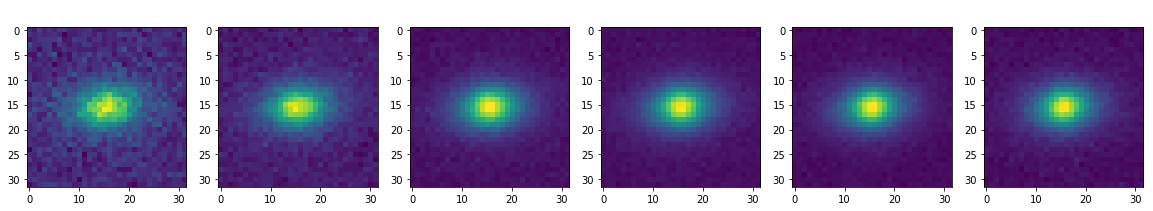

In [30]:
fig=plt.figure(figsize=(20,10))
rows, columns = 1,6
cont = 0
filters =['N','I','R','vis','u','g','r','i','z','y']

for i in range(4,10) :
    cont +=1
    fig.add_subplot(rows, columns, cont)
    max_b = np.max(b)
    plt.imshow(b[i,16:48,16:48])#/max_b)
    plt.title(filters[i], color="w", fontsize=20)
    #plt.colorbar()

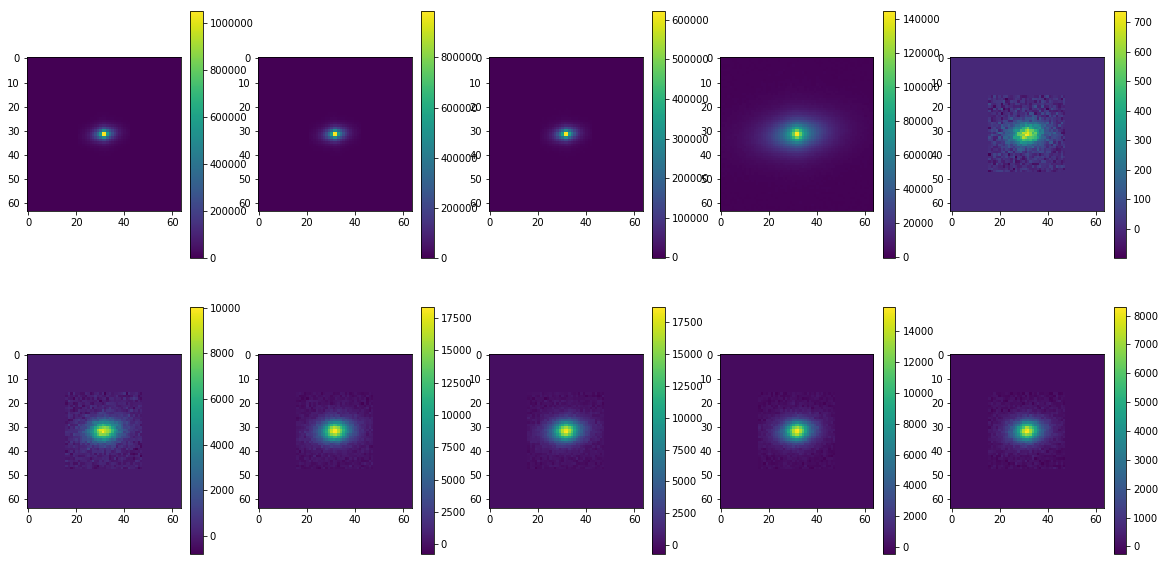

In [25]:
fig=plt.figure(figsize=(20,10))
rows, columns = 2,5
cont = 0
for i in range(0,10) :
    cont +=1
    fig.add_subplot(rows, columns, cont)
    plt.imshow(b[i])
    plt.colorbar()

# Plot functions

In [7]:
def plot_rgb(ugrizy_img, ax=None):
    RGB_img = np.zeros((stamp_size,stamp_size,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img.reshape(10,stamp_size,stamp_size)
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [8]:
def plot_rgb_vis(ugrizy_img, ax=None):
    RGB_img = np.zeros((stamp_size,stamp_size,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img.reshape(10,stamp_size,stamp_size)
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(ugrizy_img[3], a_min=0.0, a_max=None) / max_img)

In [9]:
def plot_rgb_lsst(ugrizy_img, ax=None):
    RGB_img = np.zeros((int(stamp_size/2),int(stamp_size/2),3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img[:,int(stamp_size/4):int(stamp_size*3/4),int(stamp_size/4):int(stamp_size*3/4)].reshape(10,int(stamp_size/2),int(stamp_size/2))
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

Test

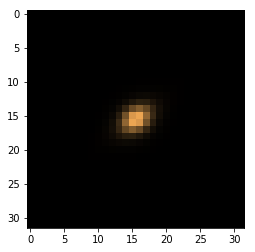

In [11]:
plot_rgb_lsst(a.reshape(10,stamp_size,stamp_size))    

# Test the generator and plot the output to check for diversity

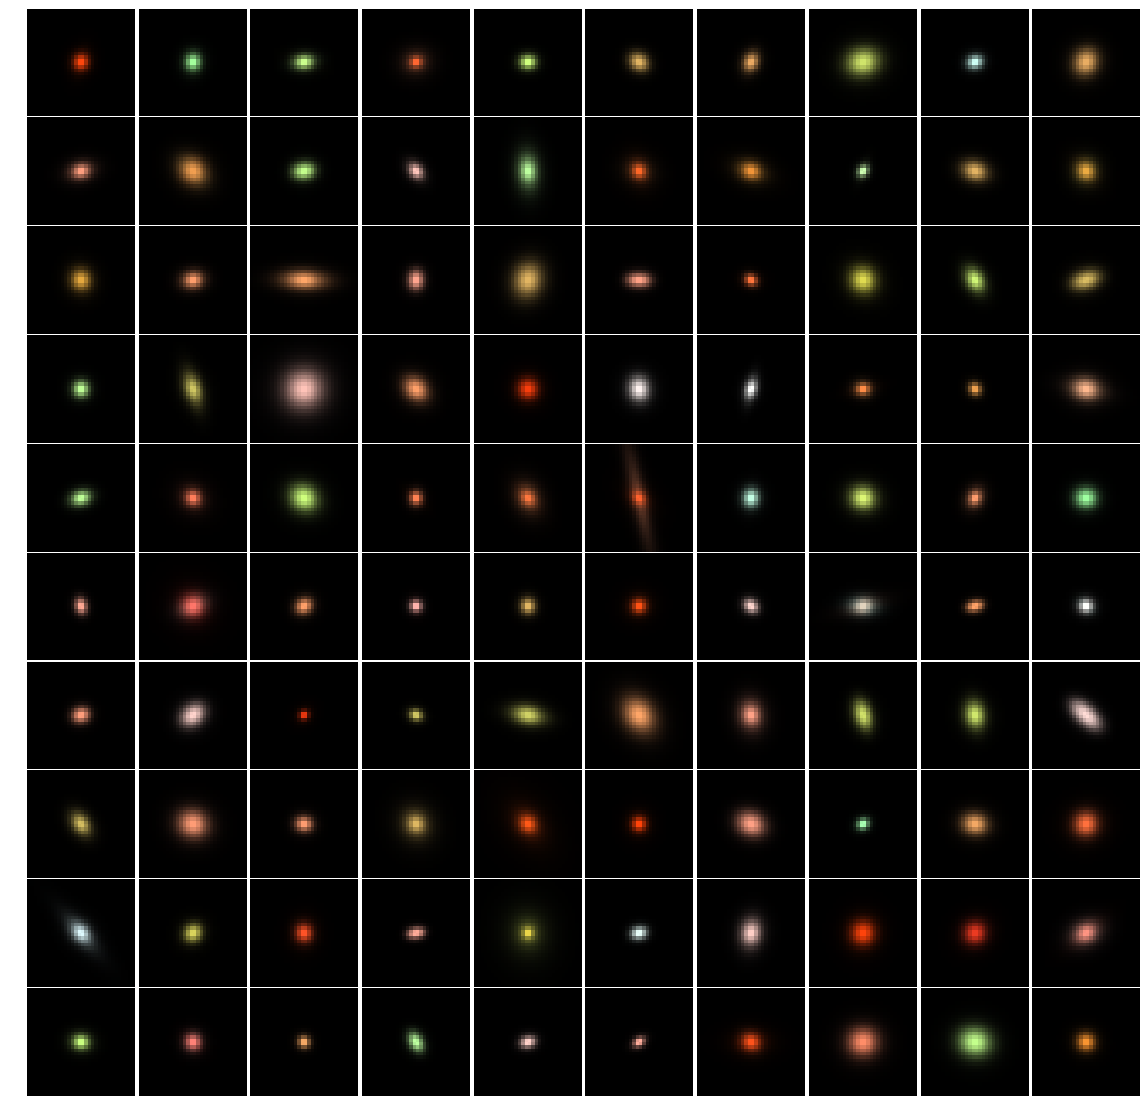

In [16]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        plot_rgb_lsst(Gal_generator_noisy()[0].reshape(10,stamp_size,stamp_size), ax=axes[i,j])        
        axes[i,j].axis('off')

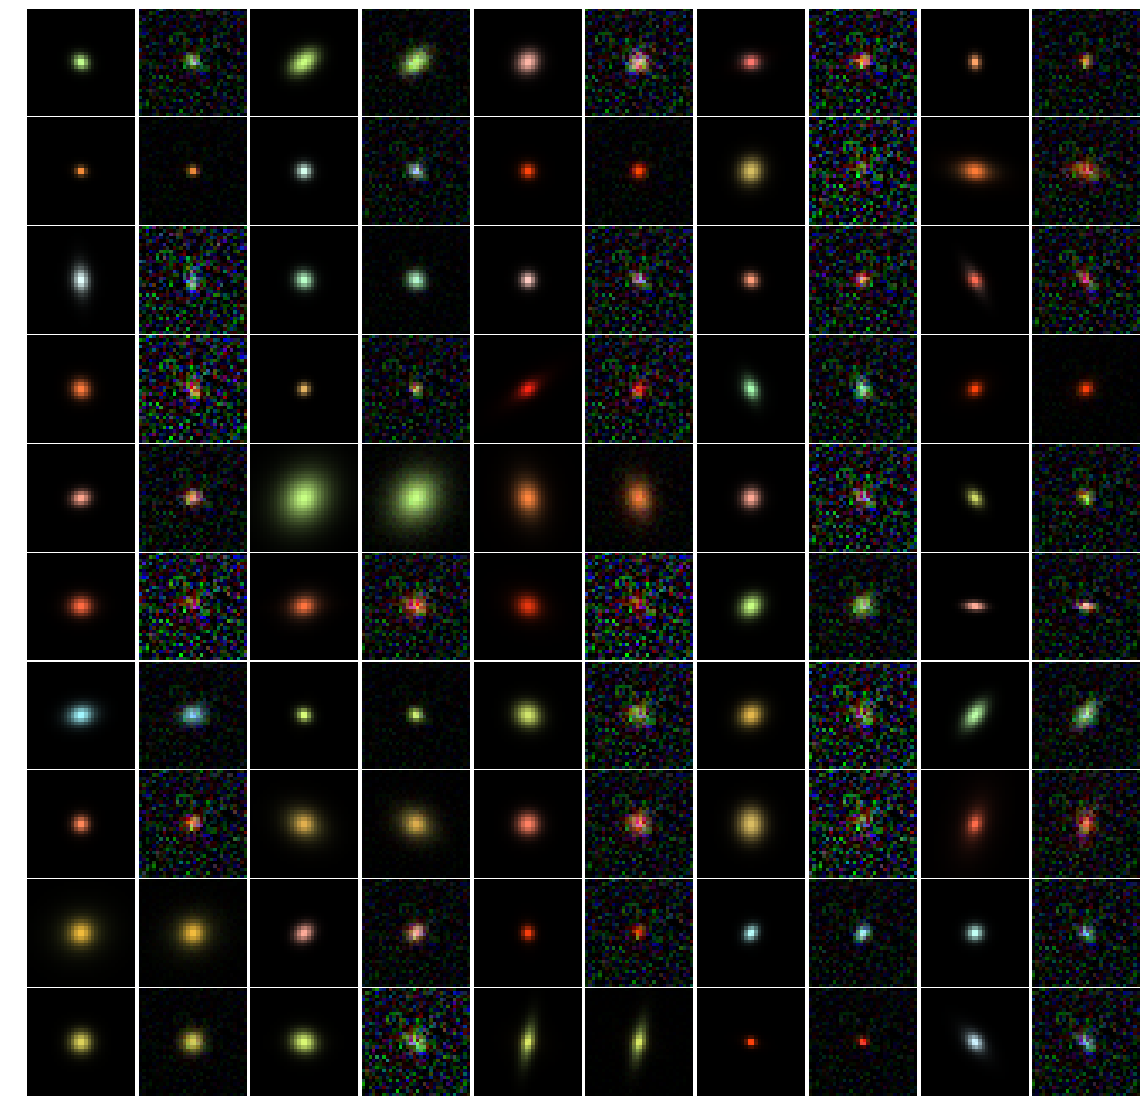

In [17]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        noiseless, noisy, redshift = Gal_generator_noisy()
        plot_rgb_lsst(noiseless.reshape(10,stamp_size,stamp_size), ax=axes[i,j]) 
        plot_rgb_lsst(noisy.reshape(10,stamp_size,stamp_size), ax=axes[i,j+1]) 
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')

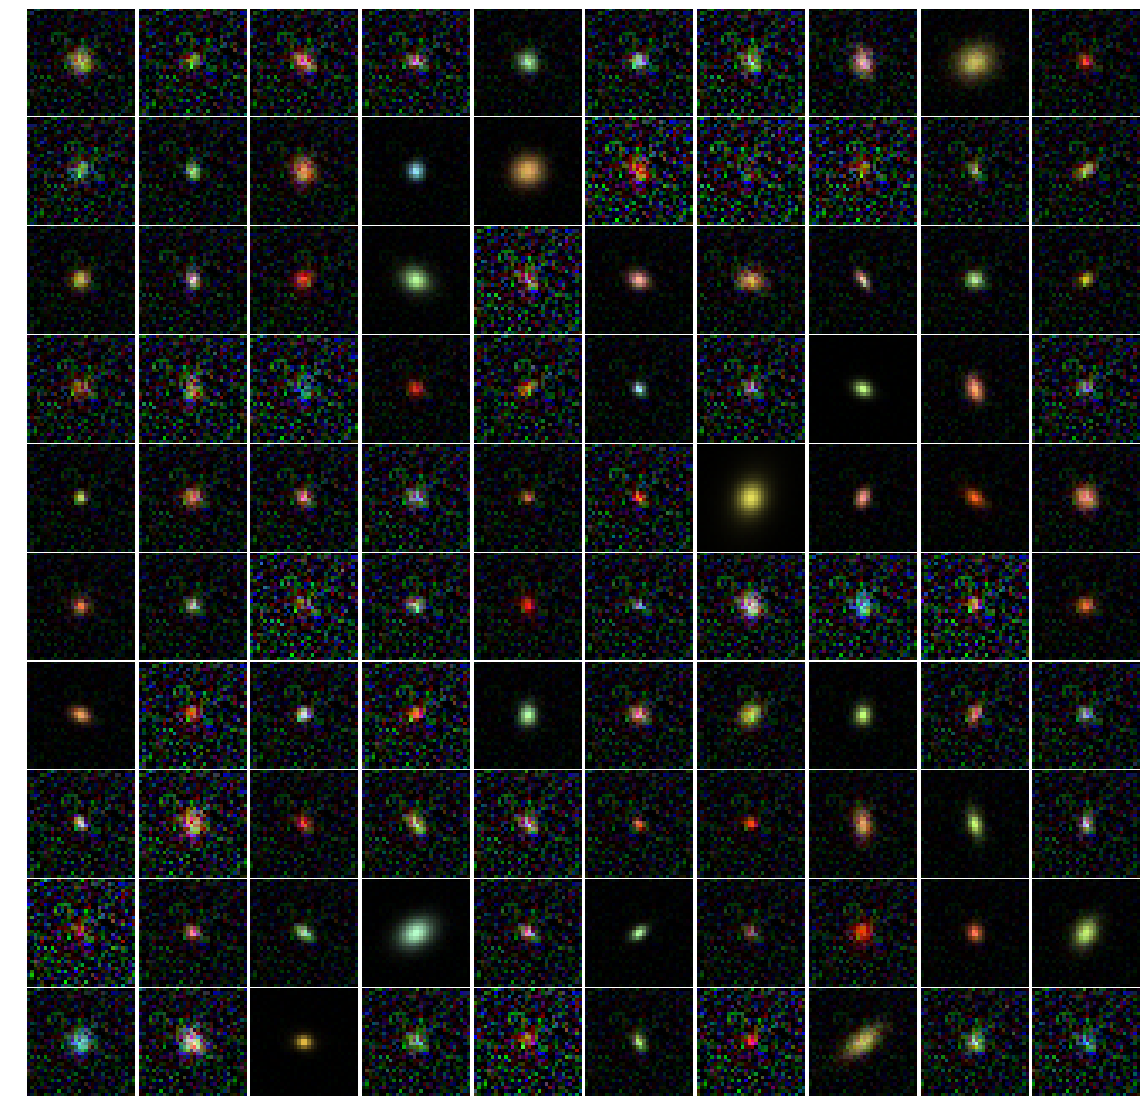

In [18]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        noiseless, noisy, redshift = Gal_generator_noisy()
        plot_rgb_lsst(noisy.reshape(10,stamp_size,stamp_size), ax=axes[i,j]) 
        axes[i,j].axis('off')

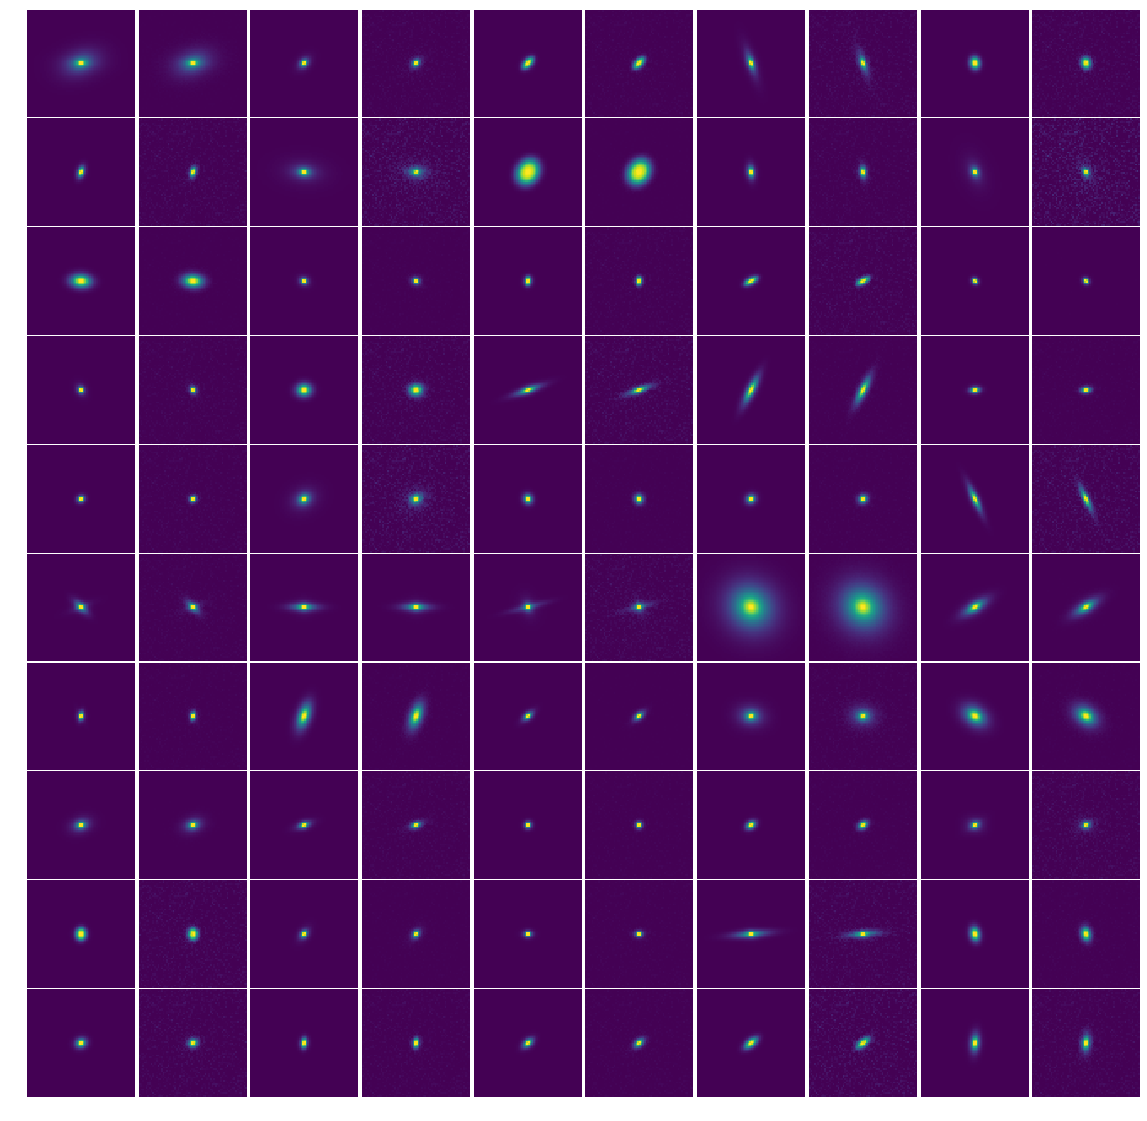

In [11]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        noiseless, noisy, redshift = Gal_generator_noisy()
        plot_rgb_vis(noiseless.reshape(10,stamp_size,stamp_size), ax=axes[i,j]) 
        plot_rgb_vis(noisy.reshape(10,stamp_size,stamp_size), ax=axes[i,j+1]) 
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')

In [14]:
noiseless, noisy, redshift = Gal_generator_noisy()

In [15]:
noisy.shape

(10, 64, 64)

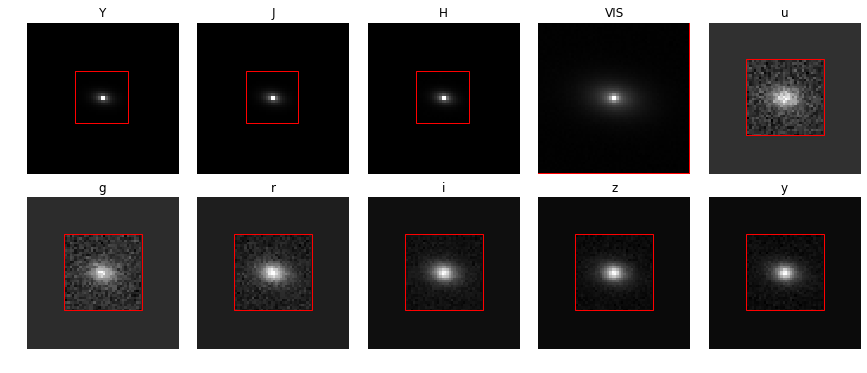

In [12]:
#N_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1, hspace=.15)

noiseless, noisy, redshift = Gal_generator_noisy()
axes[0,0].imshow(noisy.reshape(10,stamp_size,stamp_size)[0], cmap='gray') 
axes[0,1].imshow(noisy.reshape(10,stamp_size,stamp_size)[1], cmap='gray') 
axes[0,2].imshow(noisy.reshape(10,stamp_size,stamp_size)[2], cmap='gray') 
axes[0,3].imshow(noisy.reshape(10,stamp_size,stamp_size)[3], cmap='gray') 
axes[0,4].imshow(noisy.reshape(10,stamp_size,stamp_size)[4], cmap='gray') 
axes[1,0].imshow(noisy.reshape(10,stamp_size,stamp_size)[5], cmap='gray') 
axes[1,1].imshow(noisy.reshape(10,stamp_size,stamp_size)[6], cmap='gray') 
axes[1,2].imshow(noisy.reshape(10,stamp_size,stamp_size)[7], cmap='gray') 
axes[1,3].imshow(noisy.reshape(10,stamp_size,stamp_size)[8], cmap='gray') 
axes[1,4].imshow(noisy.reshape(10,stamp_size,stamp_size)[9], cmap='gray') 
axes[0,0].set_title('Y')
axes[0,1].set_title('J')
axes[0,2].set_title('H')
axes[0,3].set_title('VIS')
axes[0,4].set_title('u')
axes[1,0].set_title('g')
axes[1,1].set_title('r')
axes[1,2].set_title('i')
axes[1,3].set_title('z')
axes[1,4].set_title('y')
axes[0,0].axis('off')
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')
axes[0,4].axis('off')
axes[1,0].axis('off')
axes[1,1].axis('off')
axes[1,2].axis('off')
axes[1,3].axis('off')
axes[1,4].axis('off')

import matplotlib.patches as patches
rect_nir = patches.Rectangle((20,20),22,22,linewidth=1,edgecolor='r',facecolor='none')
rect_nir2 = patches.Rectangle((20,20),22,22,linewidth=1,edgecolor='r',facecolor='none')
rect_nir3 = patches.Rectangle((20,20),22,22,linewidth=1,edgecolor='r',facecolor='none')
rect_vis = patches.Rectangle((-1,-1),64,64,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst2 = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst3 = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst4 = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst5 = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')
rect_lsst6 = patches.Rectangle((15,15),33,32,linewidth=1,edgecolor='r',facecolor='none')

axes[0,0].add_patch(rect_nir)
axes[0,1].add_patch(rect_nir2)
axes[0,2].add_patch(rect_nir3)

axes[0,3].add_patch(rect_vis)

axes[0,4].add_patch(rect_lsst)
axes[1,0].add_patch(rect_lsst2)
axes[1,1].add_patch(rect_lsst3)
axes[1,2].add_patch(rect_lsst4)
axes[1,3].add_patch(rect_lsst5)
axes[1,4].add_patch(rect_lsst6)

# Plot the redshift distribution of the generated galaxies

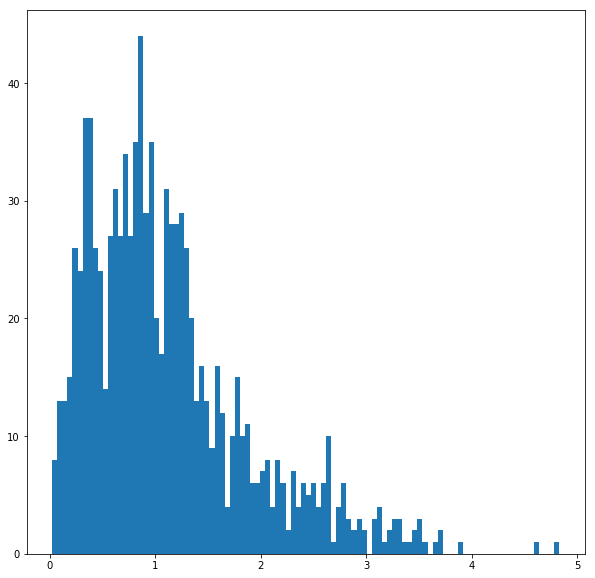

In [12]:
N_plot = 1000
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.01)
redshift = np.zeros((N_plot))

for i in range(N_plot):
    #print(i)
    noiseless, noisy, redshift[i] = Gal_generator_noisy()
    
_= plt.hist(redshift,bins=100)

# Multiprocessing generation of the galaxies

In [10]:
# function to check if S/N > 2
# Here we do the detection in R band of LSST

from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve

def SNR(gal_noiseless,gal_noisy):
    condition = False
    #g = Gaussian2DKernel(x_stddev=10)
    #img_convolv_noisy = convolve(gal_noisy[6], g)
    #img_convolv_noiseless = convolve(gal_noiseless[6], g)
    max_img_noisy = np.max(gal_noisy[6])
    max_img_noiseless = np.max(gal_noiseless[6])
    
    snr = abs(max_img_noiseless/(max_img_noisy-max_img_noiseless))
    if snr>2 : 
        condition = True
    else:
        condition = False

    return condition

In [11]:
import multiprocessing
import time

def map_f(args):
    f, i, v = args
    v.value += 1
    return f(i)
    
def map(func, iter, verbose=True, timesleep=15.0, timeout=None):
    """
    Maps the function func over the iterator iter in a multi-threaded way using the multiprocessing package
    
    func must be pickable, see https://docs.python.org/2/library/pickle.html#what-can-be-pickled-and-unpickled
    
    """
    pool = multiprocessing.Pool()
    m = multiprocessing.Manager()
    v = m.Value(int, 0)
    
    inputs = ((func,i,v) for i in iter) #use a generator, so that nothing is computed before it's needed :)
    
    res = pool.map_async(map_f, inputs)
    
    try :
        n = len(iter)
    except TypeError : # if iter is a generator
        n = None

    if verbose :
        while (True):
            if (res.ready()): break
            # remaining = res._number_left
            # print "Waiting for", remaining, "task chunks to complete..."
            print("# castor.parallel.map : tasks accomplished out of {0} : {1}".format(n, v.get()))
            time.sleep(timesleep)

    pool.close()
    m.shutdown()

    return res.get(timeout)

In [12]:
from multiprocess import *
count = 0
N_cosmo = 100
N_per_gal = 1

ud = galsim.UniformDeviate()
rng = galsim.BaseDeviate()

counter = 0

itr = np.arange(N_cosmo)

img_cube_list = []

import time
debut = time.time()

def func(ind):
    gal_noiseless, gal_noisy, redshift=Gal_generator_noisy()
    if (SNR(gal_noiseless,gal_noisy) == True):
        return np.array((gal_noiseless,gal_noisy, redshift))
    else:
        return func(ind+1) 

fin = time.time()
print('time : '+ str(fin-debut))

img_cube_list = map(func, itr, timesleep=10.0)

np.save('/sps/lsst/users/barcelin/data/galaxies_COSMOS_test_redshift_v3.npy', img_cube_list)

time : 0.00018906593322753906
# castor.parallel.map : tasks accomplished out of 100 : 0
# castor.parallel.map : tasks accomplished out of 100 : 94


# Eye check of the generated galaxies

In [6]:
a = np.load('/sps/lsst/users/barcelin/data/galaxies_COSMOS_2.npy')

In [6]:
b = np.load('/sps/lsst/users/barcelin/data/galaxies_COSMOS_val.npy')

In [7]:
print(b.shape)

(1000, 2, 10, 64, 64)


In [11]:
for i in range (1000):
    print(np.max(b[i,1]))

4198100.0
680246.0
796200.0
311957.0
592545.0
708200.0
250200.0
447080.0
274620.0
254947.0
210700.0
319300.0
385464.0
1502600.0
180900.0
4448500.0
1700700.0
438500.0
219003.0
450613.0
620600.0
451481.0
596886.0
2487881.0
953400.0
228900.0
191500.0
332800.0
214300.0
253100.0
205800.0
456400.0
464120.0
957002.0
405300.0
294792.0
1286900.0
359400.0
205580.0
1005000.0
351127.0
246931.0
1026600.0
4244588.0
894541.0
702300.0
607550.0
3739554.0
432562.0
309900.0
325100.0
370356.0
643900.0
152393.0
659462.0
318700.0
156900.0
198750.0
254515.0
2639450.0
682695.0
4009615.0
7603428.0
1321899.0
384262.0
311788.0
4153716.0
331100.0
8559444.0
526200.0
169460.0
172500.0
333400.0
318917.0
610199.0
2759166.0
663286.0
193194.0
706127.0
1104700.0
404280.0
363000.0
555300.0
172960.0
1025100.0
182800.0
367750.0
215500.0
229240.0
1005500.0
224094.0
165700.0
432700.0
274676.0
164100.0
306424.0
411708.0
930320000.0
335131.0
456809.0
630191.0
223500.0
219400.0
593690.0
14373763.0
357400.0
1372243900.0
195458.0

372741.0
937678.0
356502.0
318105.0
263699.0
293250.0
557630.0
2121058.0
1667522.0
550045.0
606750.0
354300.0
452600.0
5418485.0
2973925.0
723090.0
403581.0


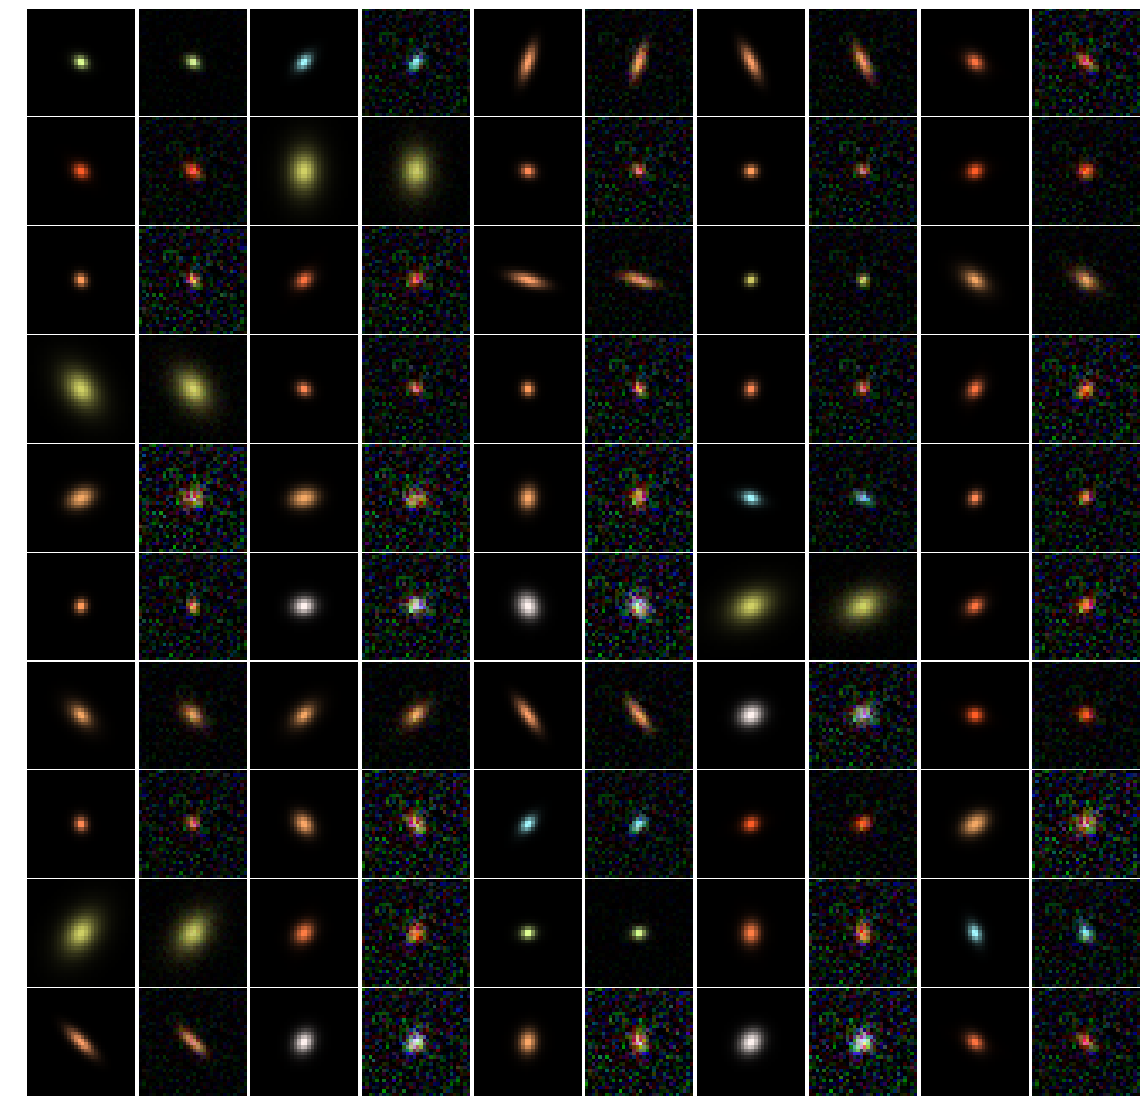

In [8]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot_rgb_lsst(b[indices[i*N_plot+j]][0].reshape(10,stamp_size,stamp_size), ax=axes[i,j])
        plot_rgb_lsst(b[indices[i*N_plot+j]][1].reshape(10,stamp_size,stamp_size), ax=axes[i,j+1])
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')

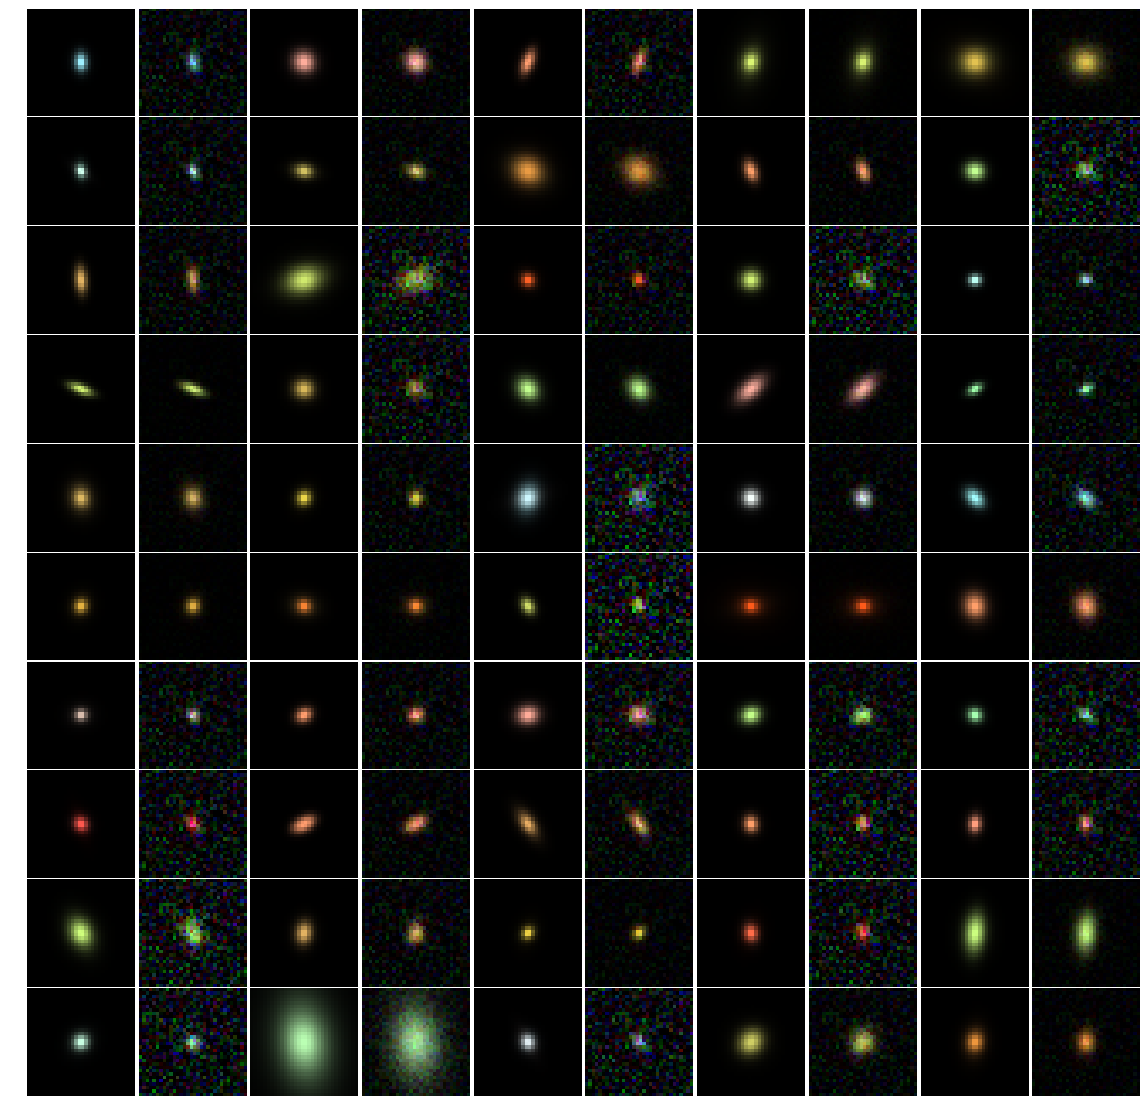

In [8]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot_rgb_lsst(a[indices[i*N_plot+j]][0].reshape(10,stamp_size,stamp_size), ax=axes[i,j])
        plot_rgb_lsst(a[indices[i*N_plot+j]][1].reshape(10,stamp_size,stamp_size), ax=axes[i,j+1])
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')